# Per Phase Datasets

When running this notebook, the output will be 5 different datasets, each corresponding to a different phase of the multi-step attack present in DARPA 2000. Each dataset will contain only the attack samples related to that specific phase, and all the benign samples present in the dataset.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

from data_prep_func import prep_process_save_data

In [2]:
SEED = 123

In [3]:
# Config
ip_encoding = "none"
feature_set = ["duration", "proto", "orig_bytes", "resp_bytes", "orig_pkts", "resp_pkts"]

## Load Data

In [4]:
SCENARIO_ONE_INSIDE_CSV = "../../data/DARPA_2000/Scenario_One/inside/inside_labeled_flows_all.csv"
data_out_root_dir = "processed_data/scenario_one/inside/stratified/unbalanced/per_phase"

In [5]:
df = pd.read_csv(SCENARIO_ONE_INSIDE_CSV)
df.head()

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,orig_bytes,resp_bytes,orig_pkts,resp_pkts,conn_state,local_orig,local_resp,attack_id,attack,phase
0,f0,9.524389e+08,9.524389e+08,0.101800,172.16.112.50,33354,172.16.114.50,80,tcp,http,290,7897,8,9,SF,T,T,0,0,0
1,f1,9.524389e+08,9.524389e+08,0.001107,172.16.114.50,45135,172.16.115.20,53,udp,dns,44,131,1,1,SF,T,T,0,0,0
2,f2,9.524389e+08,9.524389e+08,0.064488,172.16.113.204,22641,172.16.112.100,25,tcp,smtp,623,247,12,22,SF,T,T,0,0,0
3,f3,9.524389e+08,9.524389e+08,0.001167,172.16.112.100,1061,172.16.115.20,53,udp,dns,90,131,2,1,SF,T,T,0,0,0
4,f4,9.524389e+08,9.524389e+08,0.000861,172.16.113.204,1438,172.16.115.20,53,udp,dns,45,131,1,1,SF,T,T,0,0,0


## Prepare New Label Columns

In [6]:
df_w_labels = df.copy()
df_w_labels.head()
for phase in range(1,6): 
    column_name = f'is_phase_{phase}'
    df_w_labels[column_name] = (df_w_labels['phase'] == phase).astype(int)

In [7]:
df_w_labels.head()

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,local_orig,local_resp,attack_id,attack,phase,is_phase_1,is_phase_2,is_phase_3,is_phase_4,is_phase_5
0,f0,9.524389e+08,9.524389e+08,0.101800,172.16.112.50,33354,172.16.114.50,80,tcp,http,...,T,T,0,0,0,0,0,0,0,0
1,f1,9.524389e+08,9.524389e+08,0.001107,172.16.114.50,45135,172.16.115.20,53,udp,dns,...,T,T,0,0,0,0,0,0,0,0
2,f2,9.524389e+08,9.524389e+08,0.064488,172.16.113.204,22641,172.16.112.100,25,tcp,smtp,...,T,T,0,0,0,0,0,0,0,0
3,f3,9.524389e+08,9.524389e+08,0.001167,172.16.112.100,1061,172.16.115.20,53,udp,dns,...,T,T,0,0,0,0,0,0,0,0
4,f4,9.524389e+08,9.524389e+08,0.000861,172.16.113.204,1438,172.16.115.20,53,udp,dns,...,T,T,0,0,0,0,0,0,0,0


## Create Per-Phase Datasets

In [8]:
train_size = 0.6
test_size = 1 - train_size

In [9]:
for phase in range(1,6):
    label_name = f"is_phase_{phase}"

    # Split data
    df_train, df_test = train_test_split(
        df_w_labels, test_size=test_size, stratify=df_w_labels[label_name], random_state=SEED 
    )

    prep_process_save_data(
        df_train, df_test, feature_set, ip_encoding, 
        output_dir=f"{data_out_root_dir}/phase_{phase}", 
        save=True,
        label_name=label_name
    )

Saved X, y, and preprocessing pipeline to processed_data/scenario_one/inside/stratified/unbalanced/per_phase/phase_1/
Saved X, y, and preprocessing pipeline to processed_data/scenario_one/inside/stratified/unbalanced/per_phase/phase_2/
Saved X, y, and preprocessing pipeline to processed_data/scenario_one/inside/stratified/unbalanced/per_phase/phase_3/
Saved X, y, and preprocessing pipeline to processed_data/scenario_one/inside/stratified/unbalanced/per_phase/phase_4/
Saved X, y, and preprocessing pipeline to processed_data/scenario_one/inside/stratified/unbalanced/per_phase/phase_5/


## Dataset Balancing 

In [10]:
from data_balance_func import check_class_distribution, sample_classes_random

### Data Exploration

In [11]:
# Check class distributions
for phase in range(1,6):
    print(f"Phase {phase}:")
    labels = df_w_labels[f"is_phase_{phase}"]
    counts = Counter(labels)
    print(counts)
    print()

Phase 1:
Counter({0: 125805, 1: 20})

Phase 2:
Counter({0: 125803, 1: 22})

Phase 3:
Counter({0: 125790, 1: 35})

Phase 4:
Counter({0: 125803, 1: 22})

Phase 5:
Counter({0: 92071, 1: 33754})



### Upsample

In [12]:
mode = 'upsample'
desired_target = 10000
print(f'Balancing mode: {mode}')
print(f'Desired target: {desired_target}\n')

Balancing mode: upsample
Desired target: 10000



In [13]:
phase = 1
label_name = f"is_phase_{phase}"
labels = df_train[label_name]

In [14]:
df_train_upsampled, _ = sample_classes_random(
    mode=mode, 
    X=df_train, 
    y=labels, 
    phases_to_sample=[1], 
    desired_target=desired_target
)

df_train_upsampled.head()

Before sampling: Counter({0: 75485, 1: 10})
Sampling strategy (per-phase target): {1: 10000}
After sampling: Counter({0: 75485, 1: 10000})


,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,local_orig,local_resp,attack_id,attack,phase,is_phase_1,is_phase_2,is_phase_3,is_phase_4,is_phase_5
0,f117241,9.524479e+08,9.524479e+08,0.063867,172.16.115.5,3876,208.2.188.61,80,tcp,http,...,T,F,0,0,0,0,0,0,0,0
1,f74095,9.524465e+08,9.524465e+08,0.000000,12.96.31.49,18670,131.84.1.31,31964,tcp,-,...,F,F,0,0,0,0,0,0,0,0
2,f51251,9.524465e+08,9.524465e+08,0.000000,66.107.208.60,10297,131.84.1.31,7596,tcp,-,...,F,F,5327,1,5,0,0,0,0,1
3,f59606,9.524465e+08,9.524465e+08,0.000000,109.22.20.93,12798,131.84.1.31,13138,tcp,-,...,F,F,0,0,0,0,0,0,0,0
4,f45148,9.524465e+08,9.524465e+08,0.000000,54.252.81.161,7158,131.84.1.31,6902,tcp,-,...,F,F,2209,1,5,0,0,0,0,1


Total number of samples: 85485
Phase 0: 75485 samples (88.30%)
Phase 1: 10000 samples (11.70%)


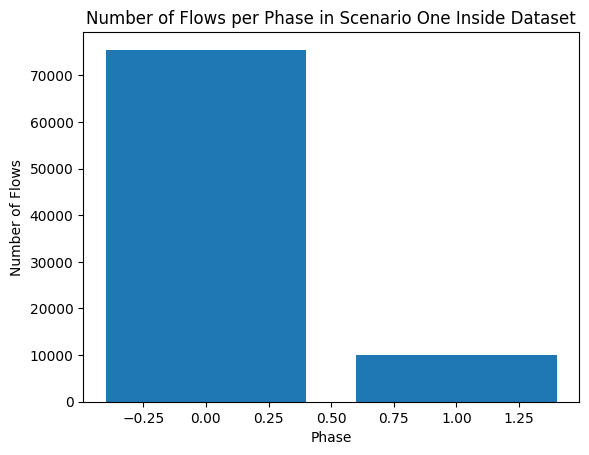

{0: 75485, 1: 10000}

In [15]:
check_class_distribution(df_train_upsampled[label_name], phases=[0,1], plot=True)

In [16]:
data_out_root_dir = "processed_data/scenario_one/inside/stratified/sampled/per_phase"

In [17]:
prep_process_save_data(
    df_train_upsampled, df_test, feature_set, ip_encoding,
    output_dir=f"{data_out_root_dir}/phase_{phase}", 
    save=True,
    label_name=label_name
)

Saved X, y, and preprocessing pipeline to processed_data/scenario_one/inside/stratified/sampled/per_phase/phase_1/
